#  Multi-label Classification

## Importing required packages

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn import metrics
from sklearn.metrics import accuracy_score, make_scorer, f1_score
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
from random import shuffle

## Task 0: Load the Tmc2007 Dataset

In [2]:
import pandas as pd

df = pd.read_csv('../data/tcm.csv',delimiter=';',encoding ='latin1')

df.head() 

,abort,abortedtakeoff,above,abuse,abusive,accomplish,acquire,acrid,across,activerunway,...,class13,class14,class15,class16,class17,class18,class19,class20,class21,class22
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X = df.iloc[:, 0:-22]

In [4]:
y = df.iloc[:,-22:]
y

,class01,class02,class03,class04,class05,class06,class07,class08,class09,class10,...,class13,class14,class15,class16,class17,class18,class19,class20,class21,class22
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28591,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28592,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
28593,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28594,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [5]:
labels =list(y.columns)

In [6]:
#labels = ['amazed-suprised', 'happy-pleased', 'relaxing-calm', 'quiet-still', 'sad-lonely', 'angry-aggresive']

In [7]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size = 0.7)

In [8]:
# Custom accuracy score based on hamming loss implementation

def get_accuracy_score(y_test,y_pred):
    
    if 'numpy' not in str(type(y_pred)):
        y_pred = y_pred.to_numpy()
        
    if 'numpy' not in str(type(y_test)):
        y_test = y_test.to_numpy()
    
    
    assert(y_test.shape == y_pred.shape)
    
    if y_pred.shape[1] <= 5: #For a smaller number of labels, a ratio of half the labels being correct is good enough
        ratio = 0.5
    else:
        ratio = 0.7 #For a number of labels, at least 70% of the predicted labels must be correct
    
    acc_rows = []
    
    for i in range(len(y_test)):
        acc_rows.append(np.count_nonzero(y_test[i]==y_pred[i]))
#         acc_rows.append(np.count_nonzero(y_test.iloc[i,:].values==y_pred.iloc[i,:].values)) #Count the number of matches
        
    acc_rows = [1 if x/y_pred.shape[1] >= ratio else 0 for x in acc_rows] #1 if ratio of match in a row is greater than ratio, else 0
    return sum(acc_rows)/len(acc_rows) # Mean accuracy


## Task 1: Implement the Binary Relevance Algorithm

In [9]:
class BinaryRelevanceClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, base_model=LogisticRegression()):
        self.base_model = base_model #base model - by default logistic regression
    
    def fit(self, X, y):
        self.model_list_ = []
        for column in y:  #For every label in y, fit the model independently
            clf = clone(self.base_model) #Clone the base model to avoid shallow copy
            A,b = check_X_y(X,y[column])
            clf.fit(A,b) #fit the model for the particular label value
            self.model_list_.append(clf) #Add the model to the saved model list
            
    def predict(self,X):
        check_is_fitted(self, ['model_list_']) 
        X = check_array(X)
        y_pred = pd.DataFrame() #Create a dataframe to save predictions
        i = 1
        for model in self.model_list_: #Make predictions for each label, using the corresponding mdodel
            y_pred_class = model.predict(X) 
            y_pred[i] = y_pred_class #Add current prediction to dataframe
            i+=1
        return y_pred.to_numpy() #return final predictions
    
    def predict_proba(self,X):
        check_is_fitted(self, ['model_list_']) #Check if model list is present
        X = check_array(X)
        y_pred = pd.DataFrame()
        i = 1
        for model in self.model_list_:
            y_pred_class = model.predict_proba(X) #Call predict_proba of the each base model
            y_pred[i] = [one_prob[1] for one_prob in y_pred_class] #Add the probability of 1 to the dataframe
            i+=1
        return y_pred.to_numpy() #return final probabilities

# 1.1 RandomForestClassifier

 RandomForestClassifier Accuracy (hamming loss) of  = 99.860124 %
--------------------------------------------------------------------------------------------------------------
RandomForestClassifier Accuracy of  = 54.225434 %
RandomForestClassifier F1 Score of  = 79.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.68      0.75       541
           1       0.80      0.91      0.85      5089
           2       0.96      0.50      0.66       140
           3       0.91      0.33      0.49       160
           4       0.90      0.79      0.84      1190
           5       0.84      0.78      0.81      2464
           6       0.92      0.44      0.59       721
           7       0.95      0.51      0.67       865
           8       0.94      0.40      0.57       161
           9       0.95      0.40      0.56       443
          10     

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


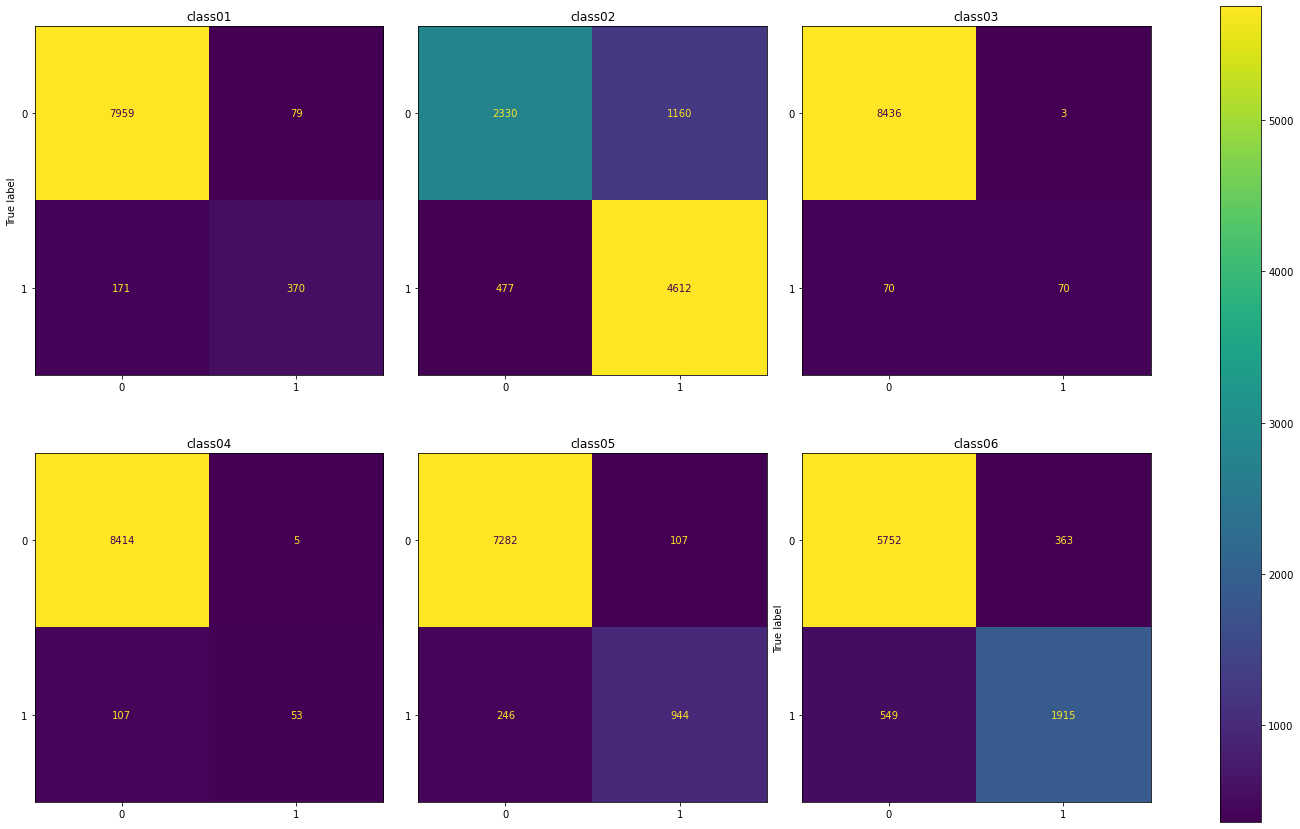

In [13]:
binclf = BinaryRelevanceClassifier(base_model=RandomForestClassifier())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" RandomForestClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("RandomForestClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("RandomForestClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 1.2 GaussianNB

 GaussianNB Accuracy (hamming loss) of  = 16.983331 %
--------------------------------------------------------------------------------------------------------------
GaussianNB Accuracy of  = 1.515328 %
GaussianNB F1 Score of  = 25.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.10      0.97      0.19       541
           1       0.67      0.90      0.77      5089
           2       0.03      0.86      0.05       140
           3       0.03      0.88      0.05       160
           4       0.18      0.97      0.31      1190
           5       0.37      0.97      0.54      2464
           6       0.12      0.98      0.21       721
           7       0.13      0.97      0.24       865
           8       0.03      0.94      0.05       161
           9       0.06      0.96      0.11       443
          10       0.03      0.84      0.05       146


C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


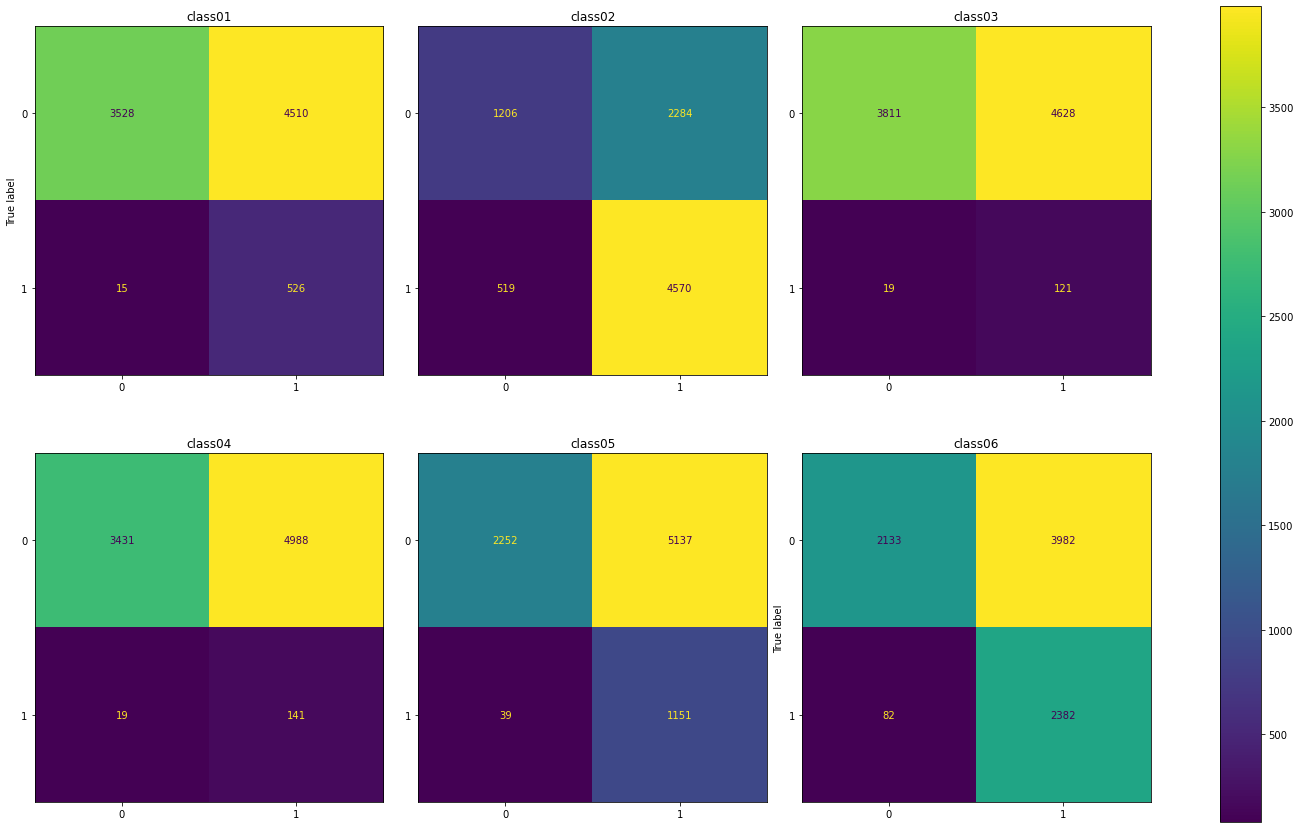

In [14]:
binclf = BinaryRelevanceClassifier(base_model=GaussianNB())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" GaussianNB Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("GaussianNB Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("GaussianNB F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 1.3 DecisionTreeClassifier

 DecisionTreeClassifier Accuracy (hamming loss) of  = 99.312274 %
--------------------------------------------------------------------------------------------------------------
DecisionTreeClassifier Accuracy of  = 44.375801 %
DecisionTreeClassifier F1 Score of  = 71.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.59      0.65      0.62       541
           1       0.79      0.76      0.77      5089
           2       0.62      0.66      0.64       140
           3       0.53      0.54      0.54       160
           4       0.75      0.76      0.76      1190
           5       0.70      0.74      0.72      2464
           6       0.54      0.59      0.57       721
           7       0.58      0.62      0.60       865
           8       0.48      0.55      0.52       161
           9       0.53      0.56      0.54       443
          10     

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


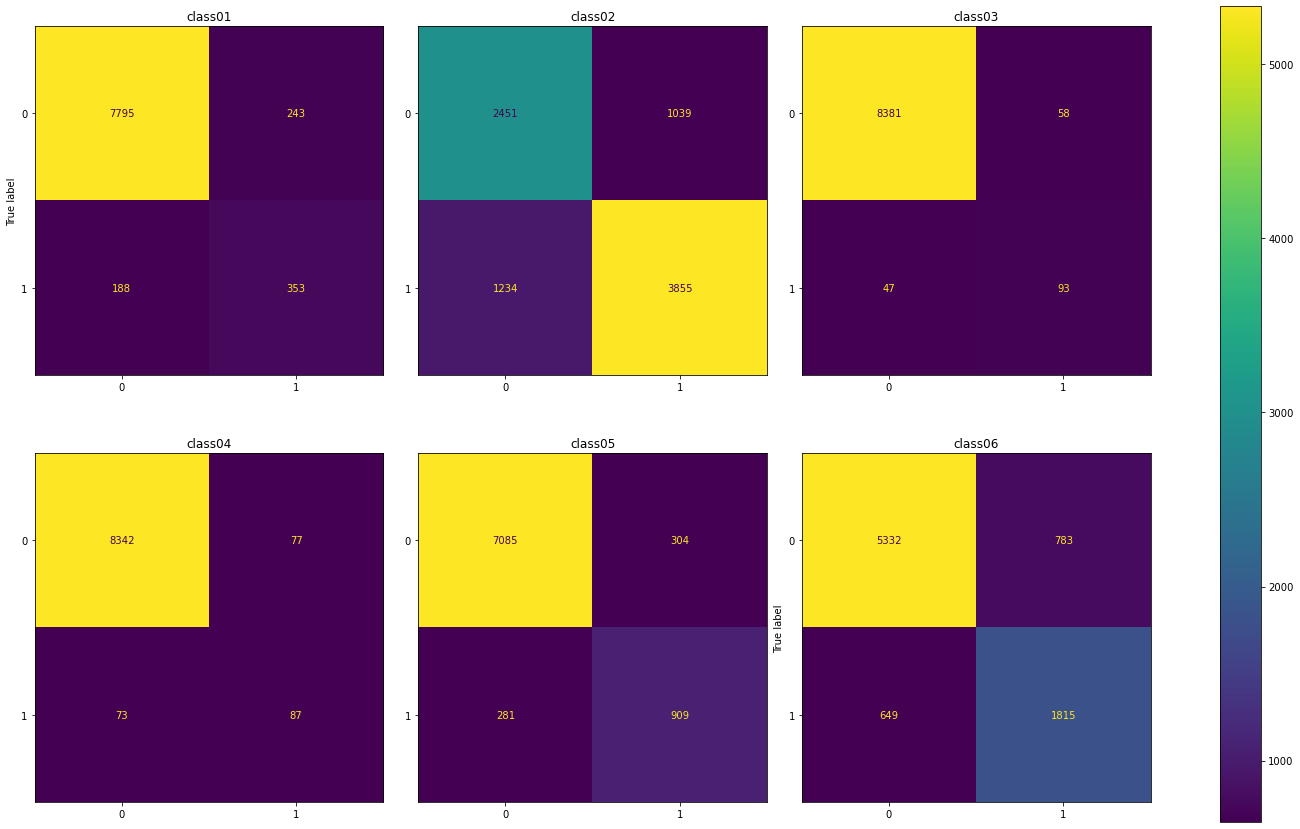

In [15]:
binclf = BinaryRelevanceClassifier(base_model=DecisionTreeClassifier())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" DecisionTreeClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("DecisionTreeClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("DecisionTreeClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 1.4 Support vector machine

 svm Accuracy (hamming loss) of  = 99.883436 %
--------------------------------------------------------------------------------------------------------------
svm Accuracy of  = 31.332323 %
svm F1 Score of  = 70.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.58      0.63       541
           1       0.69      0.88      0.78      5089
           2       0.80      0.69      0.74       140
           3       0.67      0.42      0.52       160
           4       0.82      0.72      0.76      1190
           5       0.73      0.68      0.71      2464
           6       0.00      0.00      0.00       721
           7       0.76      0.47      0.58       865
           8       0.59      0.37      0.46       161
           9       0.71      0.22      0.34       443
          10       0.77      0.40      0.53       146
          11       0

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


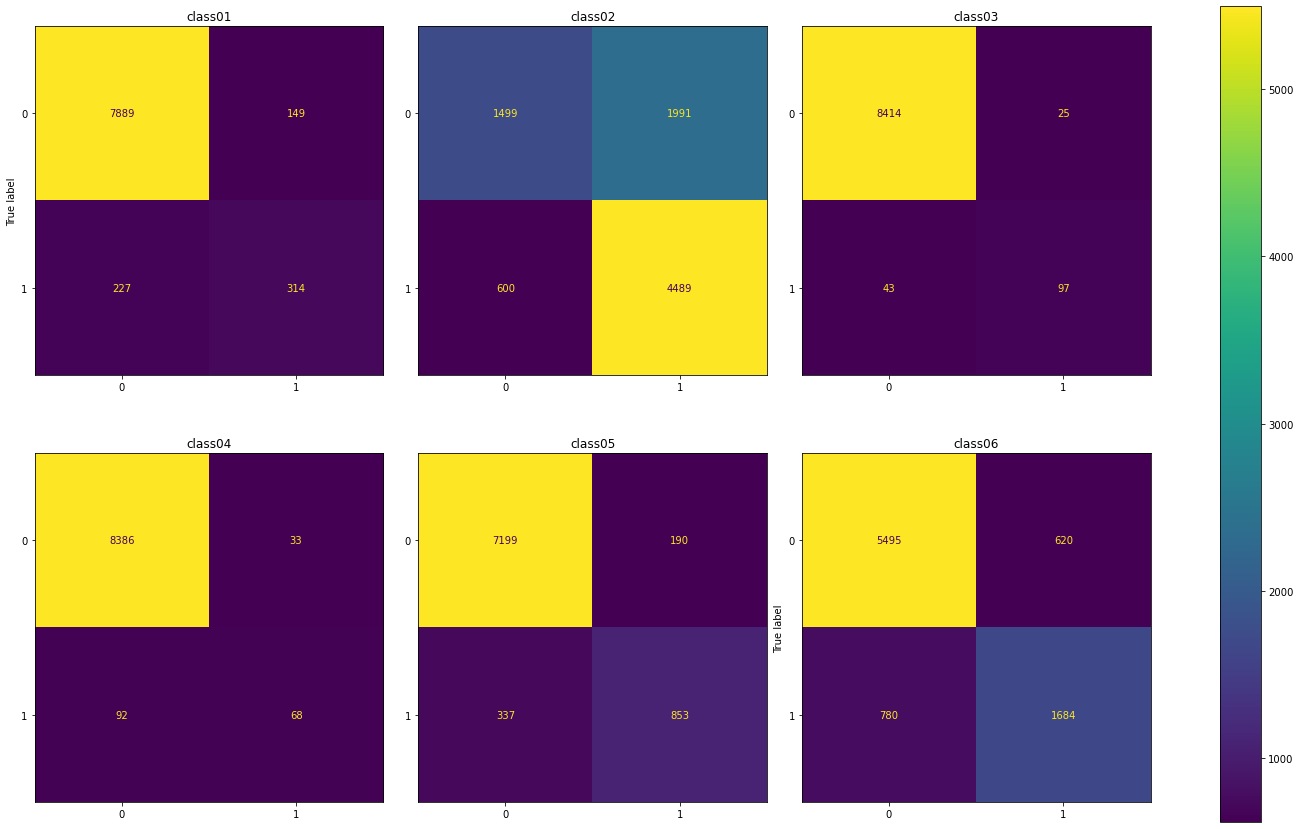

In [17]:
from sklearn import svm

binclf = BinaryRelevanceClassifier(base_model=svm.SVC(kernel='linear', C = 1.0))
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" svm Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("svm Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("svm F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 1.5 ExtraTreesClassifier

 ExtraTreesClassifier Accuracy (hamming loss) of  = 99.871780 %
--------------------------------------------------------------------------------------------------------------
ExtraTreesClassifier Accuracy of  = 54.411936 %
ExtraTreesClassifier F1 Score of  = 79.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       541
           1       0.80      0.90      0.85      5089
           2       0.96      0.51      0.67       140
           3       0.89      0.36      0.51       160
           4       0.90      0.80      0.85      1190
           5       0.84      0.79      0.81      2464
           6       0.93      0.44      0.60       721
           7       0.92      0.52      0.67       865
           8       0.97      0.40      0.57       161
           9       0.95      0.41      0.58       443
          10       0.93

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


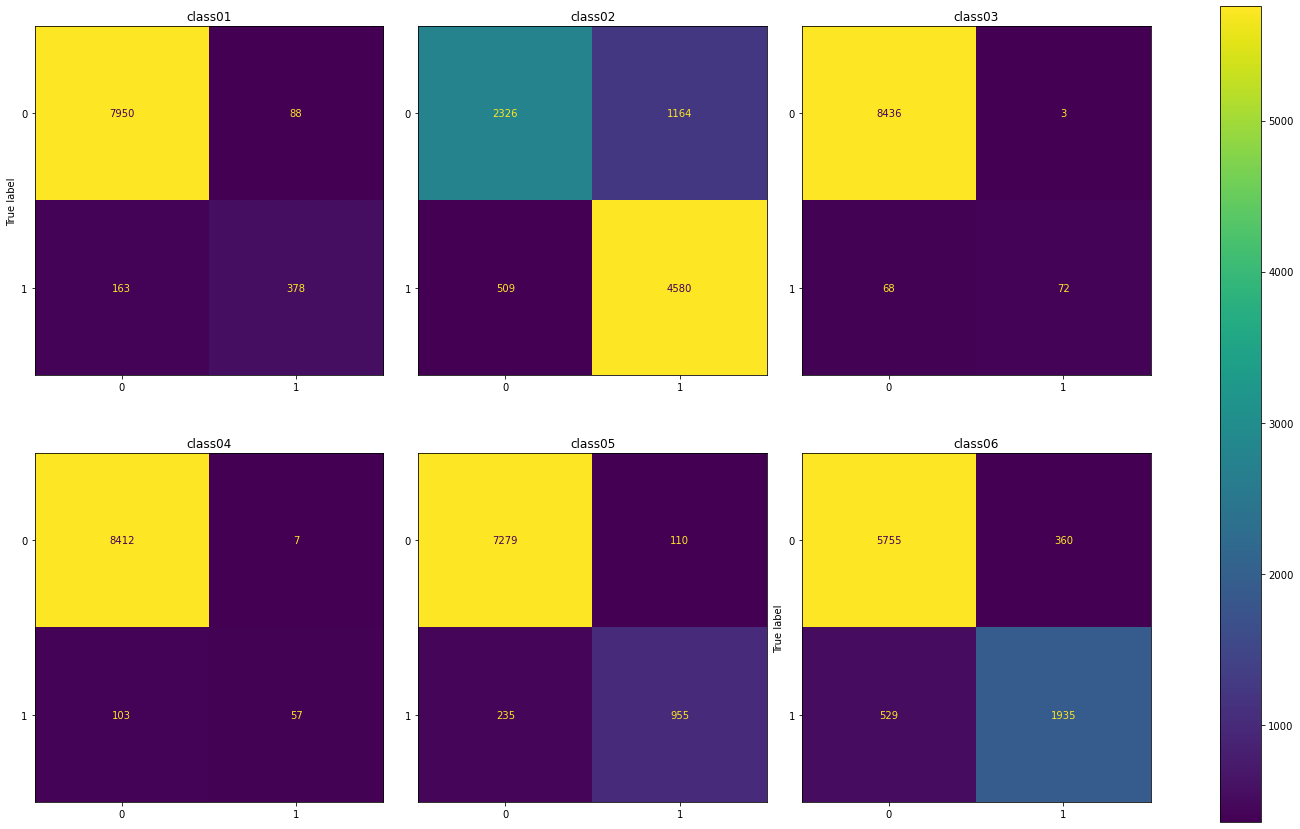

In [18]:
# 
binclf = BinaryRelevanceClassifier(base_model=ExtraTreesClassifier())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" ExtraTreesClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("ExtraTreesClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("ExtraTreesClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 1.6 AdaBoostClassifier

 AdaBoostClassifier Accuracy (hamming loss) of  = 99.895093 %
--------------------------------------------------------------------------------------------------------------
AdaBoostClassifier Accuracy of  = 25.084509 %
AdaBoostClassifier F1 Score of  = 65.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.50      0.58       541
           1       0.68      0.83      0.75      5089
           2       0.79      0.56      0.65       140
           3       0.62      0.39      0.48       160
           4       0.79      0.65      0.71      1190
           5       0.68      0.57      0.62      2464
           6       0.43      0.21      0.29       721
           7       0.61      0.37      0.46       865
           8       0.46      0.26      0.33       161
           9       0.55      0.26      0.35       443
          10       0.70      

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


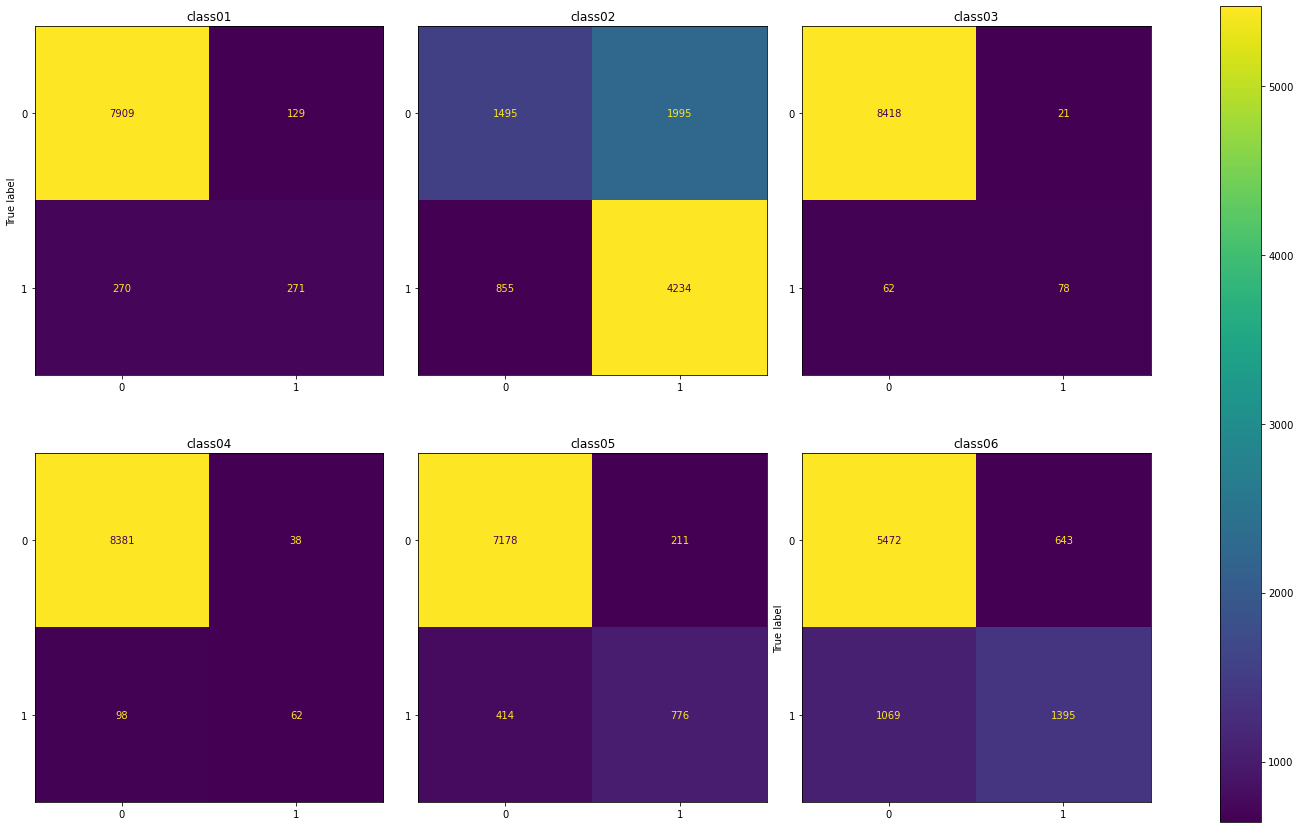

In [19]:

binclf = BinaryRelevanceClassifier(base_model=AdaBoostClassifier())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" AdaBoostClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("AdaBoostClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("AdaBoostClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

## Task 2: Implement the Classifier Chains Algorithm

In [10]:
class ClassifierChains(BaseEstimator, ClassifierMixin):
    
    def __init__(self, base_model=LogisticRegression(), order = None, undersample=False):
        self.base_model = base_model # The base estimator
        self.order = order # Order of labels in which the labels are to be sent to the classifier
        self.undersample = undersample # Whether or not to undersample
        
    def fit(self, X, y):
        X_cpy = X.copy()
        y_cpy = y.copy()
        self.order_shuffle = None
        self.base_order = list(range(len(y.columns)))
        
        if self.order is None:
            self.order_shuffle = list(range(len(y_cpy.columns))) # Same order as input
            
        elif self.order == 'random':
            self.order_shuffle = list(range(len(y_cpy.columns))) # Random label order
            random.shuffle(self.order_shuffle)
            print(self.order_shuffle)
            
        else:
            if len(self.order) == len(y.columns) and all(isinstance(item, int) for item in self.order):
                self.order_shuffle = self.order # Label order given by user
        
        y_cpy = y_cpy.iloc[:,self.order_shuffle] # Shuffle y according to label order
        
        
        self.model_list_ = []
        for column in y_cpy:
            X_cpy.reset_index(drop=True, inplace=True)
            y_cpy.reset_index(drop=True, inplace=True)
            
            X_copy = X_cpy.copy()
            
            if self.undersample:
                concat_x_y = X_copy.join(y_cpy[column]) #Concat X and the label to perform undersampling
                label_0, label_1 = sum(y_cpy[column]==0), sum(y_cpy[column])

                ratio = label_1/label_0 #Check the ratio of 1s to 0s in a target

                '''Here, we undersample only when the difference between 1 and 0 is quite large, 
                that is if the number of the majority class is more than double the number of the minority class'''

                if ratio < 0.5: # Undersample using pd.sample on label 0
                    xy_label_1 = concat_x_y[concat_x_y[column]==1]
                    xy_label_0 = concat_x_y[concat_x_y[column]==0].sample(label_1)
                    concat_x_y = pd.concat([xy_label_0, xy_label_1], axis=0)

                elif ratio >= 2: # Undersample using pd.sample on label 1
                    xy_label_1 = concat_x_y[concat_x_y[column]==1].sample(label_0) 
                    xy_label_0 = concat_x_y[concat_x_y[column]==0]
                    concat_x_y = pd.concat([xy_label_0, xy_label_1], axis=0)              

                #Separate concatenated dataset into X and y
                X_copy = concat_x_y.iloc[:,:-1]
                y_column = concat_x_y.iloc[:,-1]

            else:
                y_column = y_cpy[column]
                
            clf = clone(self.base_model)
            A,b = check_X_y(X_copy, y_column)
            clf.fit(A,b)  # Fit model to the (undersampled if true) dataset
            self.model_list_.append(clf)   # Append model to list
            y_col = pd.DataFrame(y_cpy[column])
            X_cpy = pd.concat([X_cpy, y_col], axis=1)  # Concatenate current label to X
            
            
    def predict(self,X):
        X_cpy = X.copy()
        X_cpy.reset_index(drop=True, inplace=True)
        check_is_fitted(self, ['model_list_']) # Check if the model list is present
        y_pred = pd.DataFrame() # Create a dataframe to save predictions
        i = 0
        for model in self.model_list_: # Make predictions for each label, using the corresponding mdodel
            X_cpy = check_array(X_cpy)
            y_pred_class = model.predict(X_cpy) # Predict current label
            y_pred[self.order_shuffle[i]] = y_pred_class # Save the predicted class according to our label order
            
            X_cpy = np.column_stack((X_cpy, y_pred_class)) # Append the predicted column to X test
            i+=1
            
        y_pred = y_pred.loc[:,self.base_order] # Return according to original order
        return y_pred.to_numpy() # Return as numpy array
    
    def predict_proba(self,X):
        X_cpy = X.copy()
        X_cpy.reset_index(drop=True, inplace=True)
        check_is_fitted(self, ['model_list_']) #Check if the model list is present
        y_pred = pd.DataFrame() # Create a dataframe to save predictions
        i = 0
        for model in self.model_list_: # Make prediction probabilities for each label, using the corresponding mdodel
            X_cpy = check_array(X_cpy)
            y_pred_class = model.predict(X_cpy) # Predict current label
            y_pred_class_proba = model.predict_proba(X_cpy) # Predict probabilties using current model
            y_pred[self.order_shuffle[i]] = [one_prob[1] for one_prob in y_pred_class_proba] # Save the probabilities of 1 according to our label order
            X_cpy = np.column_stack((X_cpy, y_pred_class)) # Append prediction to X test
            i+=1
        y_pred = y_pred.loc[:,self.base_order] # Return probabilities according to original order
        return y_pred.to_numpy() # Return as numpy

# 2.1 RandomForestClassifier

 RandomForestClassifier Accuracy (hamming loss) of  = 99.871780 %
--------------------------------------------------------------------------------------------------------------
RandomForestClassifier Accuracy of  = 54.854878 %
RandomForestClassifier F1 Score of  = 79.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.67      0.75       541
           1       0.80      0.90      0.84      5089
           2       0.96      0.50      0.66       140
           3       0.91      0.33      0.49       160
           4       0.89      0.79      0.84      1190
           5       0.84      0.77      0.80      2464
           6       0.92      0.45      0.60       721
           7       0.91      0.56      0.69       865
           8       0.94      0.40      0.57       161
           9       0.95      0.40      0.56       443
          10     

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


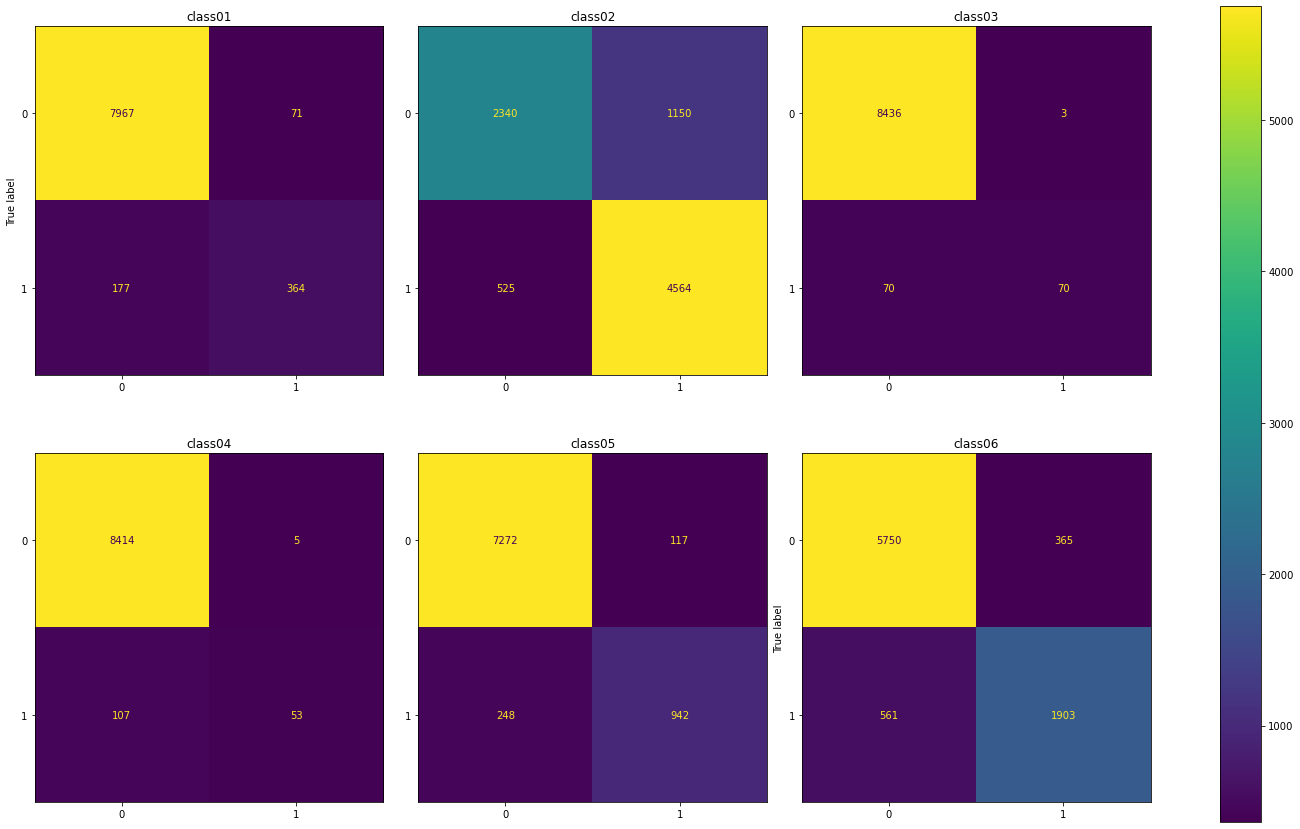

In [21]:

class_chain = ClassifierChains(base_model=RandomForestClassifier())
class_chain.fit(X_train,y_train)

y_pred_cc = class_chain.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" RandomForestClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("RandomForestClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("RandomForestClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 2.2 GaussianNB

 GaussianNB Accuracy (hamming loss) of  = 24.490034 %
--------------------------------------------------------------------------------------------------------------
GaussianNB Accuracy of  = 1.526984 %
GaussianNB F1 Score of  = 31.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.10      0.97      0.19       541
           1       0.65      0.92      0.76      5089
           2       0.03      0.86      0.05       140
           3       0.03      0.88      0.05       160
           4       0.19      0.96      0.32      1190
           5       0.43      0.94      0.59      2464
           6       0.15      0.53      0.24       721
           7       0.18      0.94      0.30       865
           8       0.03      0.94      0.05       161
           9       0.06      0.96      0.11       443
          10       0.09      0.55      0.15       146


C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


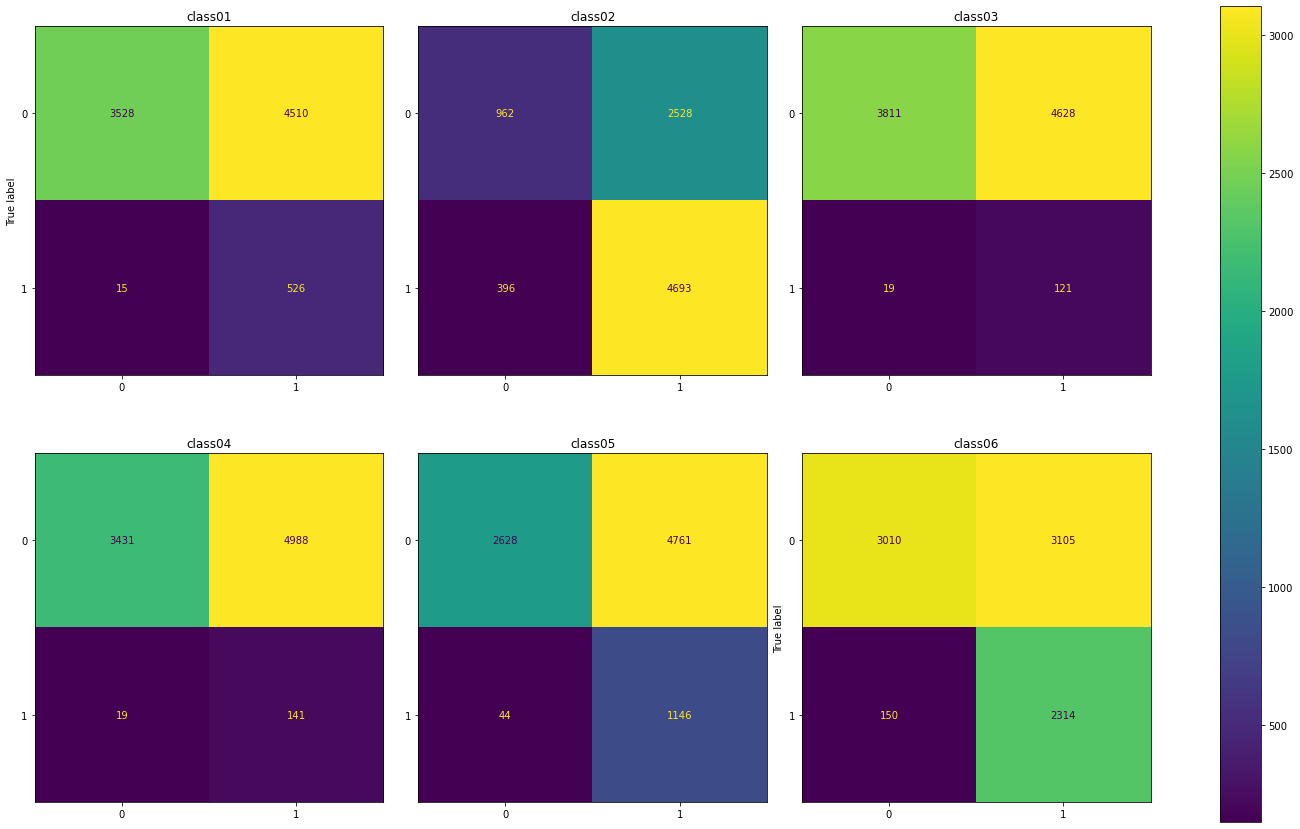

In [22]:
class_chain = ClassifierChains(base_model=GaussianNB())
class_chain.fit(X_train,y_train)
y_pred_cc = class_chain.predict(X_test) # Predictions on test data

# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" GaussianNB Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("GaussianNB Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("GaussianNB F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()  

# 2.3 DecisionTreeClassifier

 DecisionTreeClassifier Accuracy (hamming loss) of  = 99.242336 %
--------------------------------------------------------------------------------------------------------------
DecisionTreeClassifier Accuracy of  = 45.098496 %
DecisionTreeClassifier F1 Score of  = 70.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.67      0.63       541
           1       0.79      0.78      0.78      5089
           2       0.64      0.66      0.65       140
           3       0.51      0.53      0.52       160
           4       0.75      0.76      0.76      1190
           5       0.69      0.73      0.71      2464
           6       0.55      0.62      0.58       721
           7       0.57      0.59      0.58       865
           8       0.50      0.51      0.51       161
           9       0.51      0.54      0.53       443
          10     

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


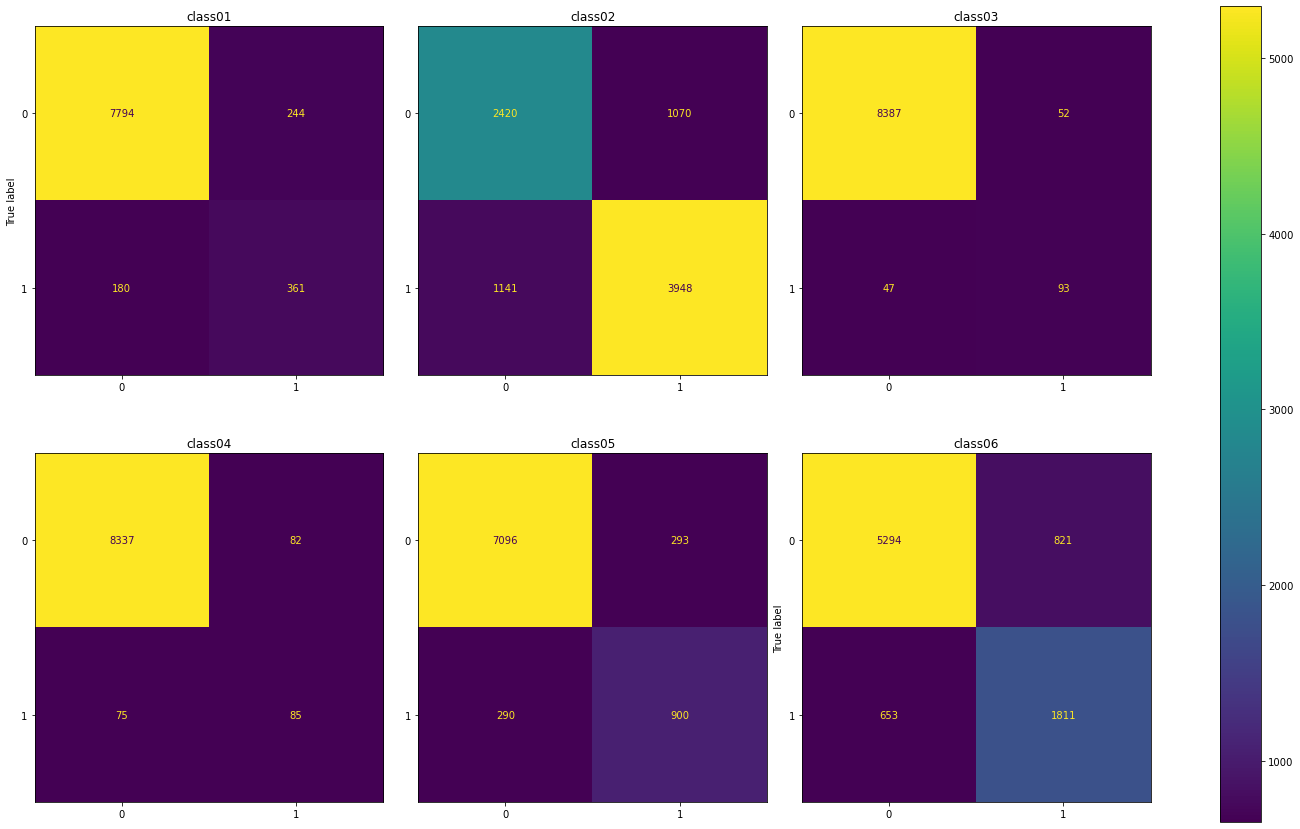

In [23]:
class_chain = ClassifierChains(base_model=DecisionTreeClassifier())
class_chain.fit(X_train,y_train)
y_pred_cc = class_chain.predict(X_test) # Predictions on test data

# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" DecisionTreeClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("DecisionTreeClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("DecisionTreeClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()  

# 2.4 Support Vector Machine

 svm Accuracy (hamming loss) of  = 99.906749 %
--------------------------------------------------------------------------------------------------------------
svm Accuracy of  = 32.404709 %
svm F1 Score of  = 70.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.58      0.63       541
           1       0.69      0.87      0.77      5089
           2       0.81      0.69      0.75       140
           3       0.69      0.44      0.53       160
           4       0.81      0.74      0.77      1190
           5       0.74      0.66      0.70      2464
           6       0.50      0.02      0.03       721
           7       0.70      0.49      0.58       865
           8       0.56      0.42      0.48       161
           9       0.69      0.20      0.31       443
          10       0.74      0.42      0.54       146
          11       0

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


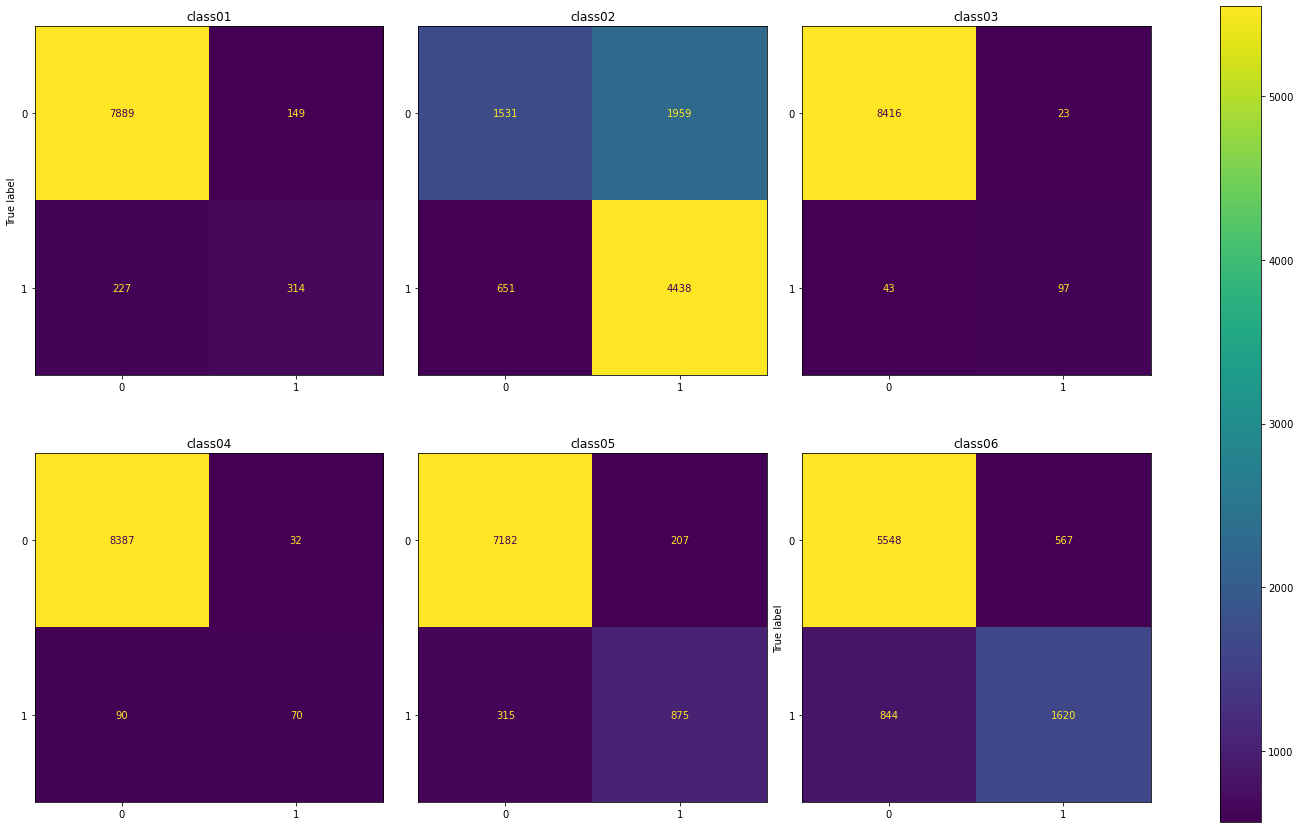

In [24]:
class_chain = ClassifierChains(base_model=svm.SVC(kernel='linear', C = 1.0))
class_chain.fit(X_train,y_train)
y_pred_cc = class_chain.predict(X_test) # Predictions on test data

# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" svm Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("svm Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("svm F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()  

# 2.5 ExtraTreesClassifier

 ExtraTreesClassifier Accuracy (hamming loss) of  = 99.871780 %
--------------------------------------------------------------------------------------------------------------
ExtraTreesClassifier Accuracy of  = 55.274508 %
ExtraTreesClassifier F1 Score of  = 79.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       541
           1       0.80      0.90      0.85      5089
           2       0.96      0.56      0.71       140
           3       0.89      0.34      0.49       160
           4       0.89      0.81      0.85      1190
           5       0.84      0.77      0.80      2464
           6       0.89      0.45      0.60       721
           7       0.90      0.56      0.69       865
           8       0.96      0.42      0.58       161
           9       0.94      0.40      0.56       443
          10       0.96

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


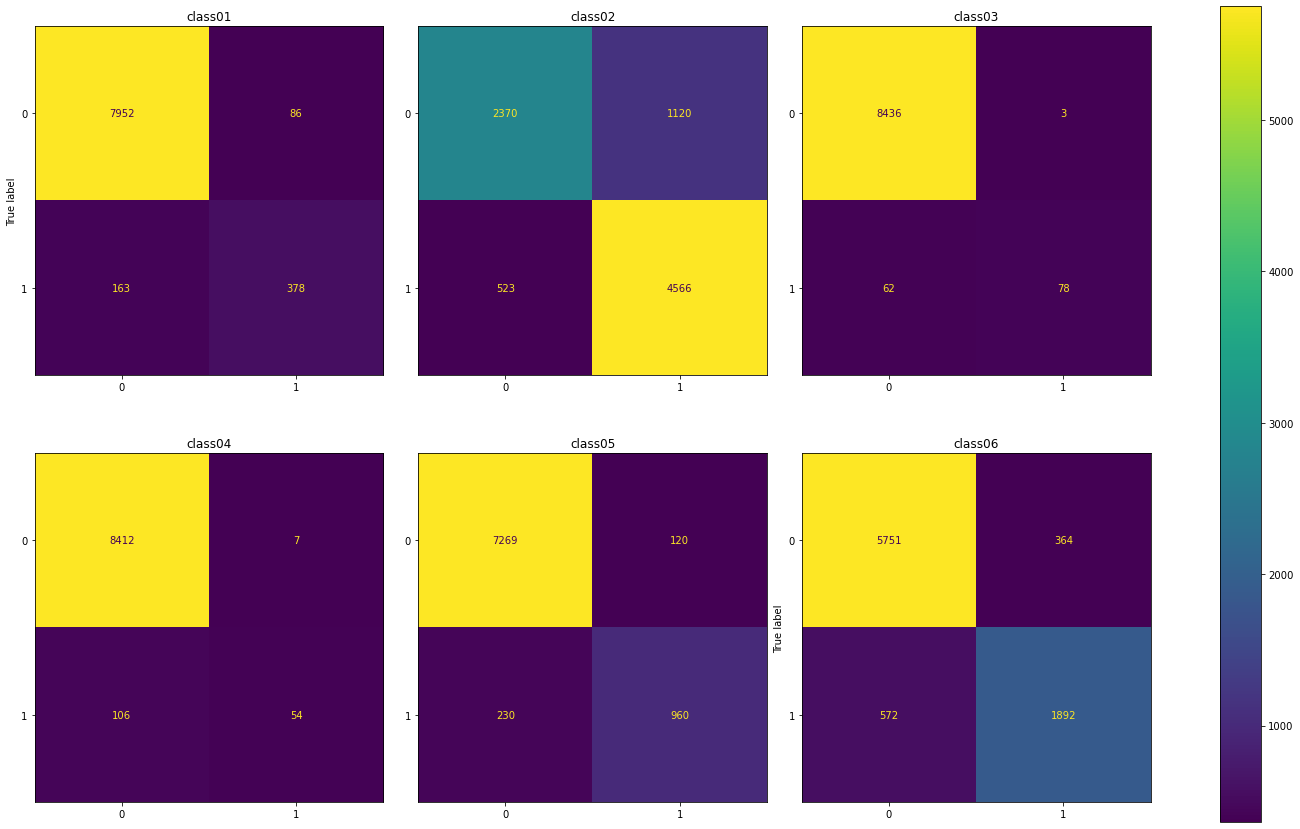

In [25]:
class_chain = ClassifierChains(base_model=ExtraTreesClassifier())
class_chain.fit(X_train,y_train)
y_pred_cc = class_chain.predict(X_test) # Predictions on test data

# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" ExtraTreesClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("ExtraTreesClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("ExtraTreesClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()  

# 2.6 AdaBoostClassifier

 AdaBoostClassifier Accuracy (hamming loss) of  = 99.860124 %
--------------------------------------------------------------------------------------------------------------
AdaBoostClassifier Accuracy of  = 27.019466 %
AdaBoostClassifier F1 Score of  = 65.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.50      0.58       541
           1       0.69      0.83      0.75      5089
           2       0.79      0.59      0.67       140
           3       0.63      0.38      0.47       160
           4       0.77      0.65      0.70      1190
           5       0.69      0.56      0.62      2464
           6       0.42      0.22      0.28       721
           7       0.63      0.41      0.49       865
           8       0.51      0.24      0.33       161
           9       0.57      0.24      0.34       443
          10       0.65      

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


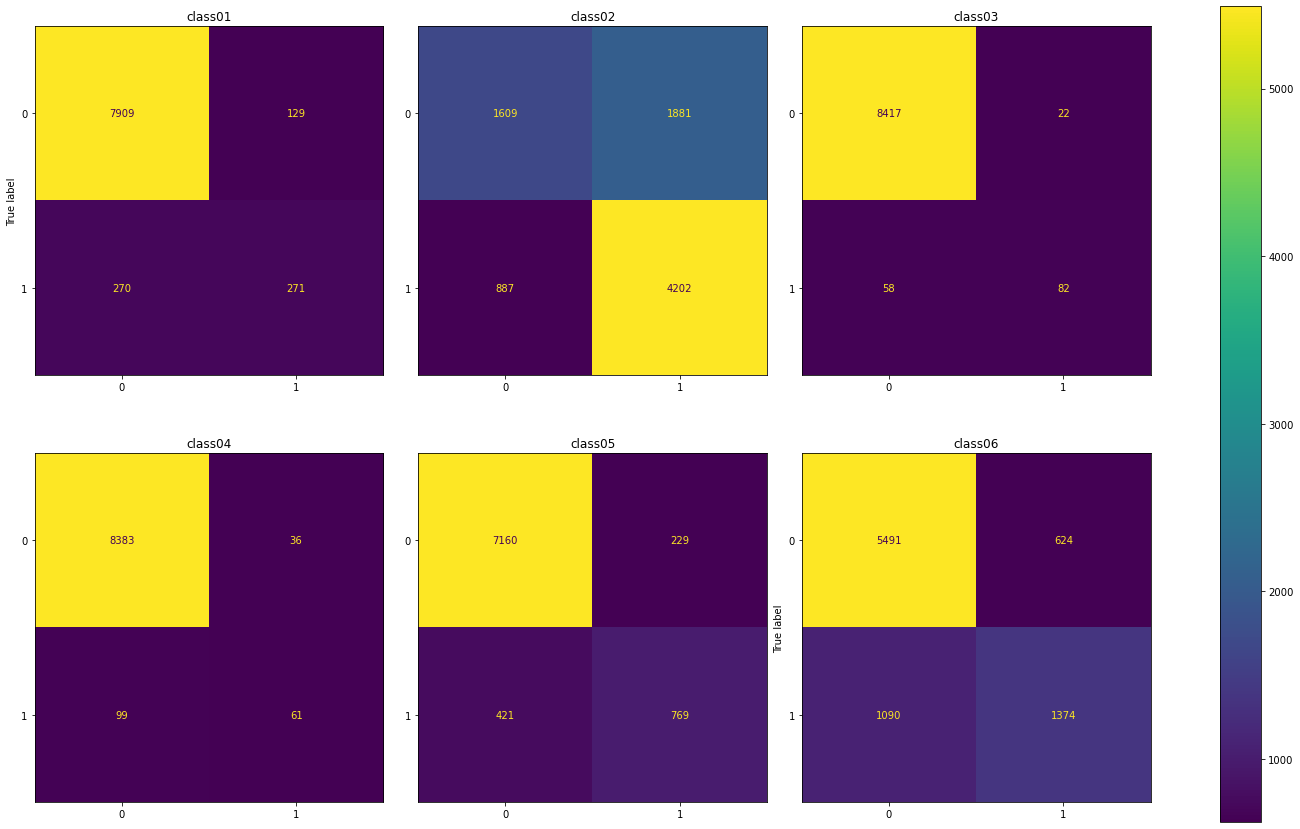

In [26]:
class_chain = ClassifierChains(base_model=AdaBoostClassifier())
class_chain.fit(X_train,y_train)
y_pred_cc = class_chain.predict(X_test) # Predictions on test data

# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" AdaBoostClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("AdaBoostClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("AdaBoostClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()  

# Task 3: Implement the LabelPowerset Algorithm


# 3.1 AdaBoostClassifier

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


--------------------------------------------------------------------------------------------------------------
AdaBoostClassifier Accuracy of  = 10.537359 %
AdaBoostClassifier F1 Score of  = 40.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       541
           1       0.63      0.96      0.76      5089
           2       0.00      0.00      0.00       140
           3       0.00      0.00      0.00       160
           4       0.00      0.00      0.00      1190
           5       0.00      0.00      0.00      2464
           6       0.00      0.00      0.00       721
           7       0.00      0.00      0.00       865
           8       0.00      0.00      0.00       161
           9       0.00      0.00      0.00       443
          10       0.56      0.03      0.06       146
          11       0.00      0.00    

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


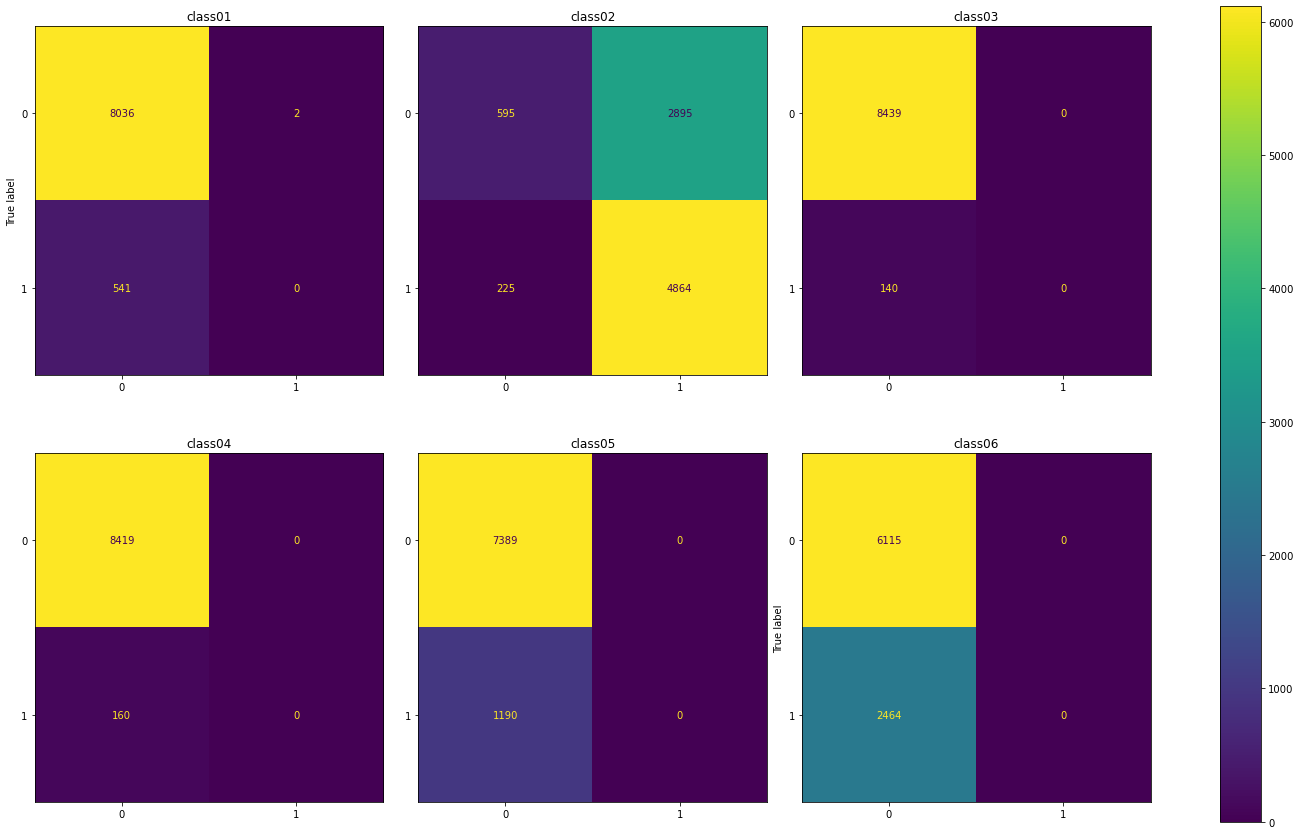

In [27]:
cla_LPowerset = LabelPowerset(AdaBoostClassifier())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
#acc_2 = get_accuracy_score(y_test,y_pred_LP) # Default accuracy score not used because it performs exact matching
#print(" AdaBoostClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("AdaBoostClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("AdaBoostClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()  

# 3.2 ExtraTreesClassifier

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


--------------------------------------------------------------------------------------------------------------
ExtraTreesClassifier Accuracy of  = 55.472666 %
ExtraTreesClassifier F1 Score of  = 78.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.83      0.75       541
           1       0.81      0.84      0.83      5089
           2       0.91      0.48      0.63       140
           3       0.89      0.31      0.46       160
           4       0.86      0.82      0.84      1190
           5       0.81      0.76      0.78      2464
           6       0.84      0.53      0.65       721
           7       0.83      0.64      0.72       865
           8       0.91      0.43      0.59       161
           9       0.94      0.38      0.54       443
          10       0.88      0.36      0.51       146
          11       0.81      0.84

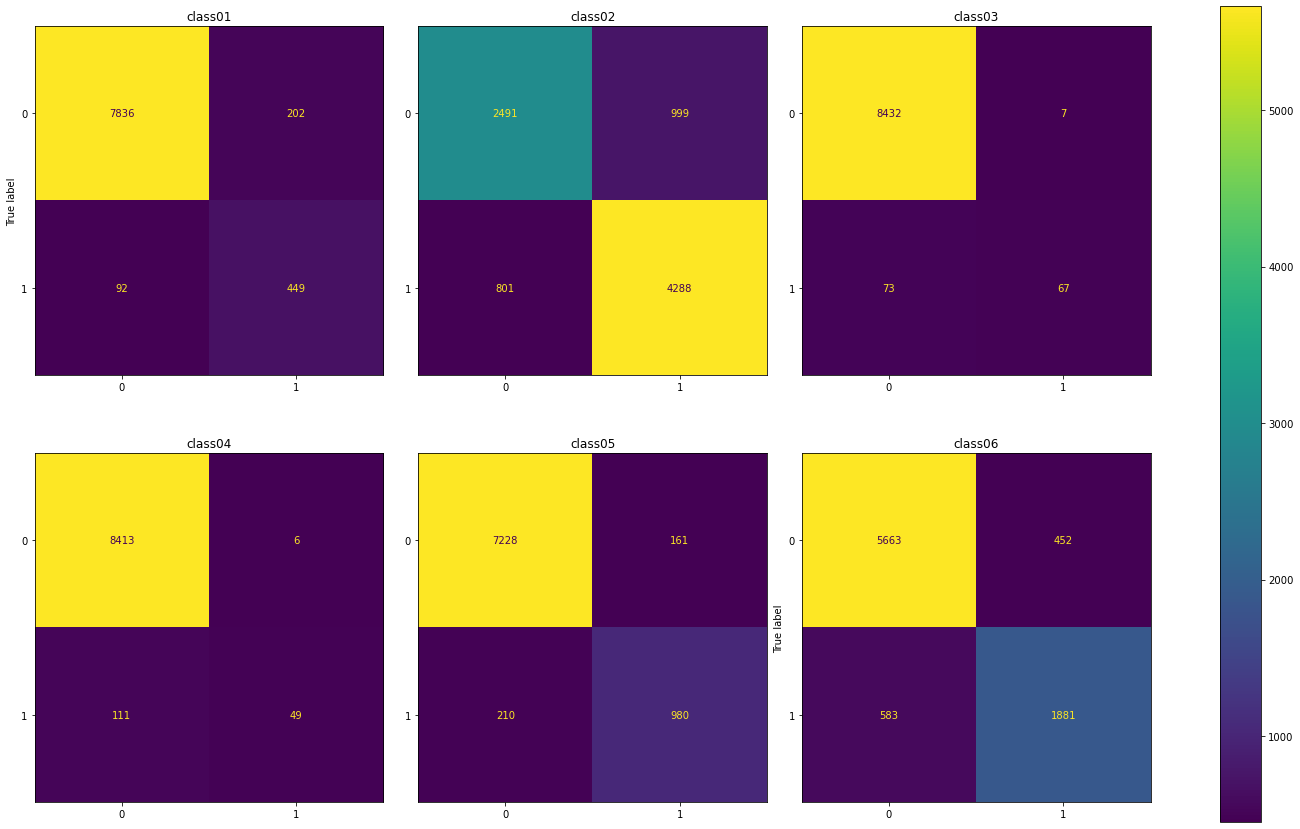

In [11]:

cla_LPowerset = LabelPowerset(ExtraTreesClassifier())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("ExtraTreesClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("ExtraTreesClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 3.3 Support Vector Machine

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


--------------------------------------------------------------------------------------------------------------
Support Vector Machine Accuracy of  = 46.648794 %
Support Vector Machine F1 Score of  = 75.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       541
           1       0.77      0.79      0.78      5089
           2       0.79      0.67      0.73       140
           3       0.74      0.55      0.63       160
           4       0.85      0.79      0.82      1190
           5       0.78      0.74      0.76      2464
           6       0.62      0.47      0.53       721
           7       0.74      0.62      0.68       865
           8       0.74      0.57      0.64       161
           9       0.76      0.51      0.61       443
          10       0.79      0.53      0.63       146
          11       0.82      

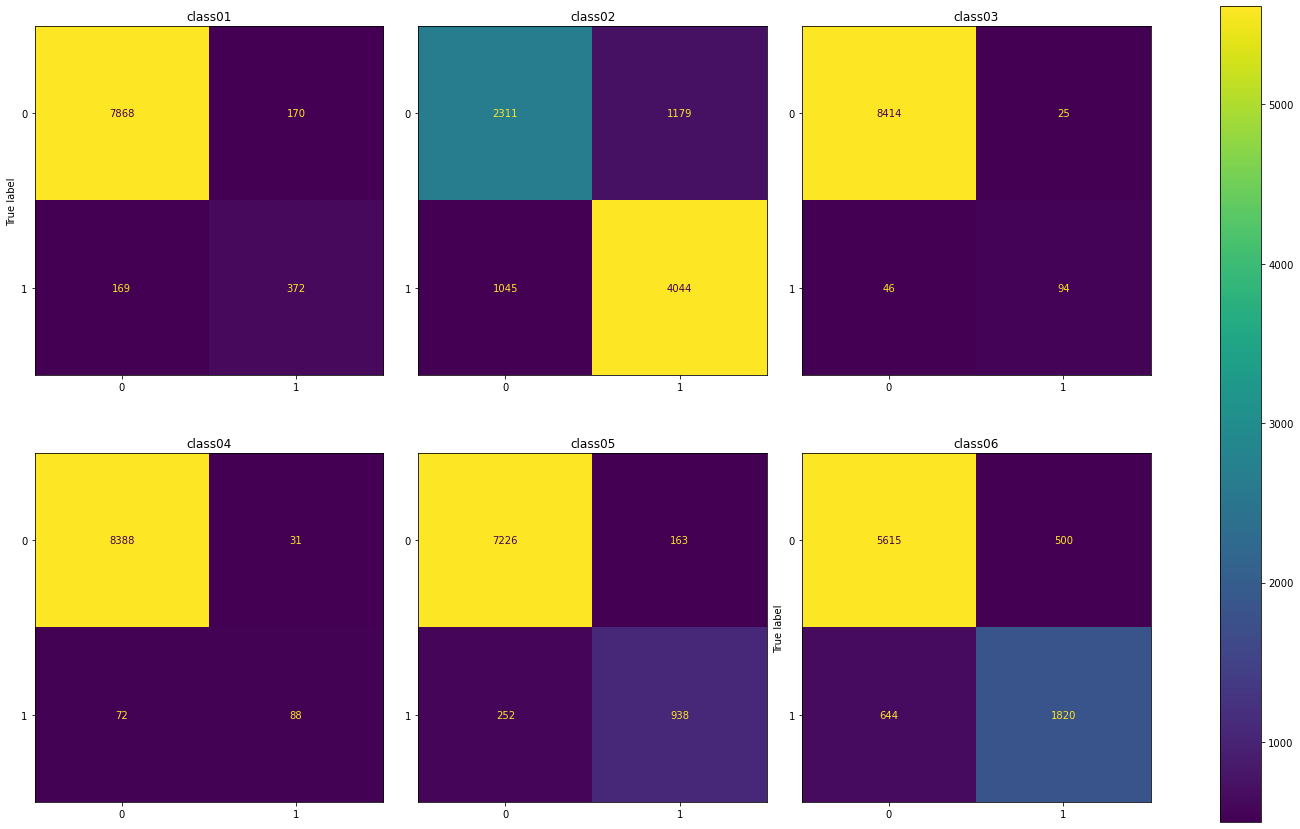

In [13]:
from sklearn import svm

cla_LPowerset = LabelPowerset(svm.SVC(kernel='linear', C = 1.0))
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("Support Vector Machine Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("Support Vector Machine F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 3.4 DecisionTreeClassifier

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


--------------------------------------------------------------------------------------------------------------
DecisionTreeClassifier Accuracy of  = 46.718732 %
DecisionTreeClassifier F1 Score of  = 70.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.66      0.66       541
           1       0.79      0.77      0.78      5089
           2       0.52      0.49      0.50       140
           3       0.45      0.40      0.42       160
           4       0.73      0.73      0.73      1190
           5       0.70      0.74      0.72      2464
           6       0.57      0.59      0.58       721
           7       0.60      0.60      0.60       865
           8       0.55      0.47      0.51       161
           9       0.51      0.46      0.48       443
          10       0.64      0.43      0.52       146
          11       0.71      

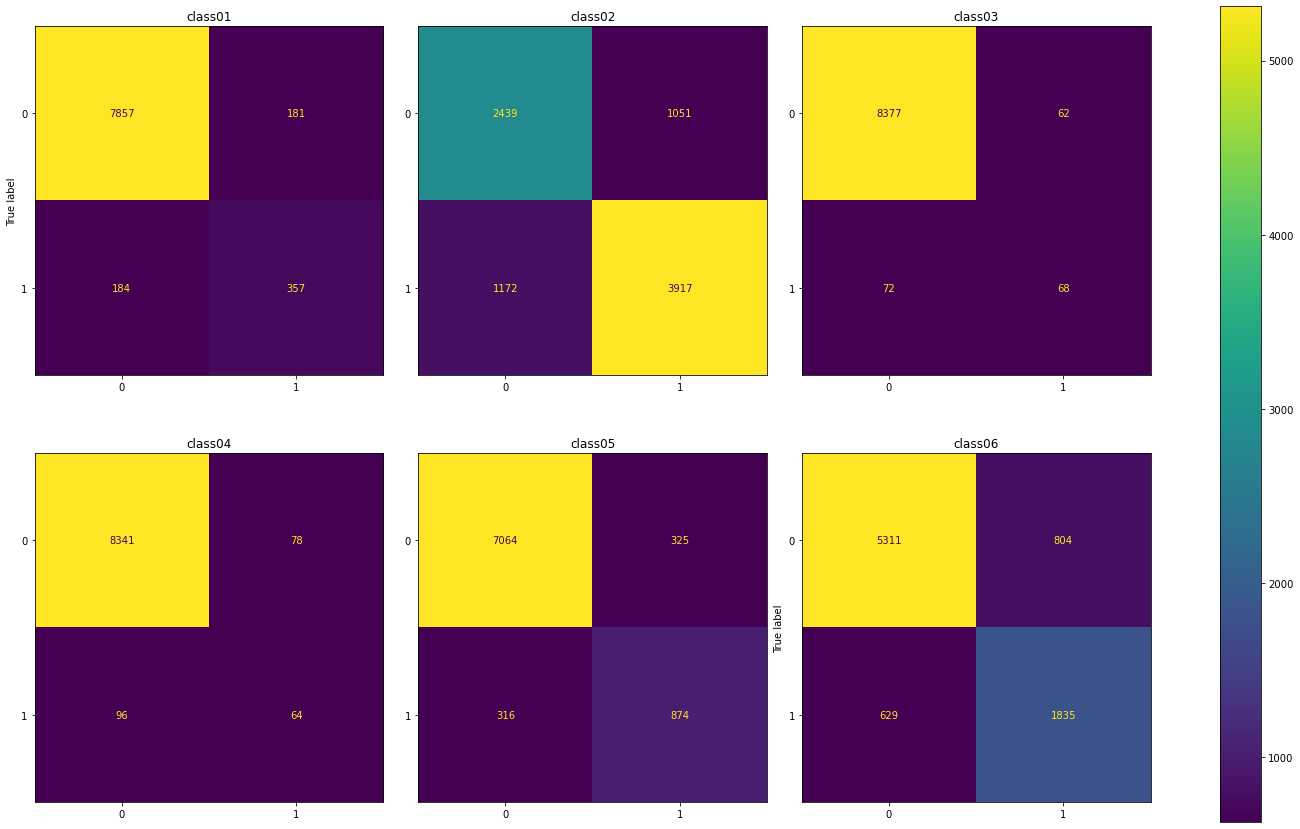

In [14]:

cla_LPowerset = LabelPowerset(DecisionTreeClassifier())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("DecisionTreeClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("DecisionTreeClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 3.5 GaussianNB

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


--------------------------------------------------------------------------------------------------------------
GaussianNB Accuracy of  = 13.859424 %
GaussianNB F1 Score of  = 56.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.54      0.52       541
           1       0.69      0.62      0.66      5089
           2       0.21      0.54      0.31       140
           3       0.30      0.42      0.35       160
           4       0.67      0.69      0.68      1190
           5       0.57      0.62      0.60      2464
           6       0.28      0.50      0.36       721
           7       0.35      0.50      0.41       865
           8       0.22      0.50      0.31       161
           9       0.35      0.48      0.41       443
          10       0.29      0.49      0.37       146
          11       0.59      0.69      0.64      1344

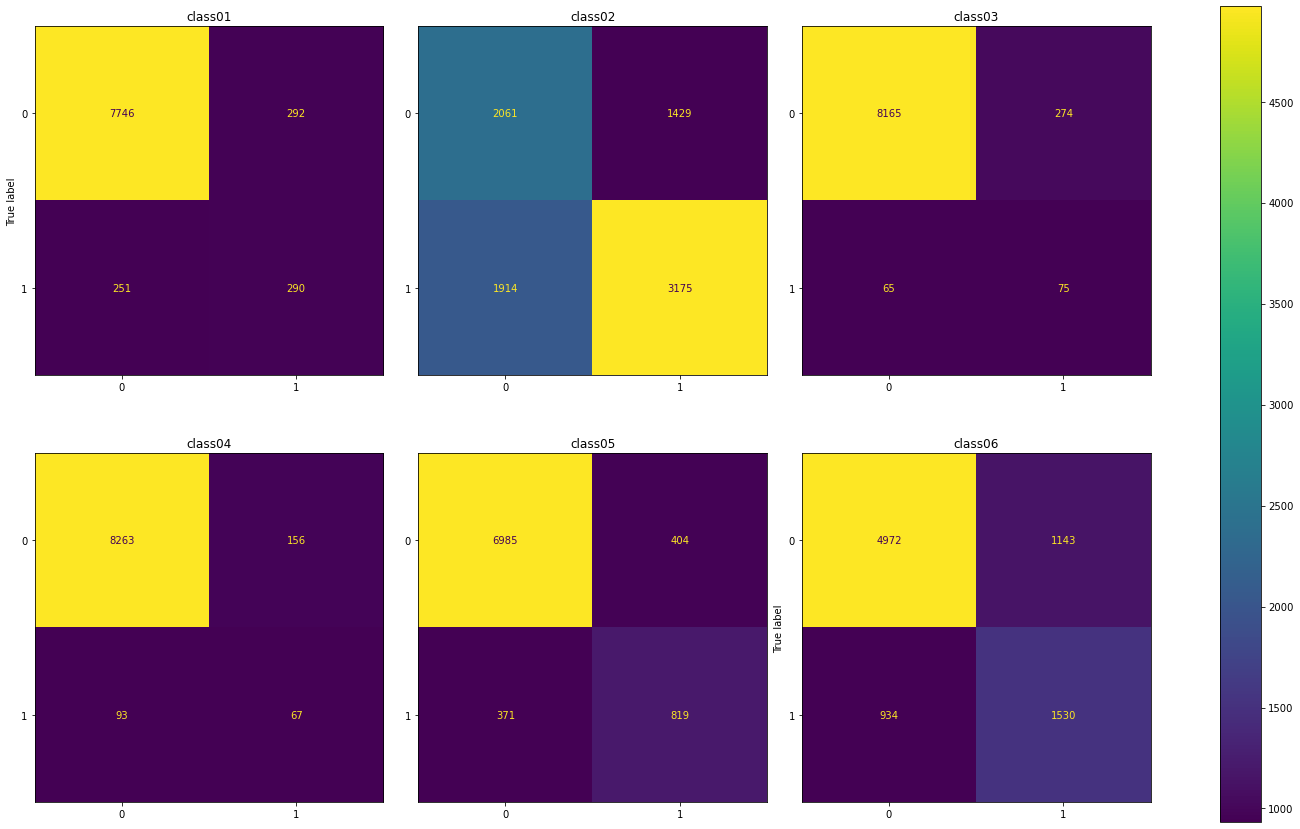

In [15]:

cla_LPowerset = LabelPowerset(GaussianNB())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("GaussianNB Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("GaussianNB F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 3.6 RandomForestClassifier

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


--------------------------------------------------------------------------------------------------------------
RandomForestClassifier Accuracy of  = 54.913160 %
RandomForestClassifier F1 Score of  = 77.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.83      0.75       541
           1       0.80      0.84      0.82      5089
           2       0.94      0.45      0.61       140
           3       0.93      0.33      0.49       160
           4       0.85      0.82      0.84      1190
           5       0.80      0.76      0.78      2464
           6       0.84      0.52      0.64       721
           7       0.81      0.61      0.70       865
           8       0.96      0.43      0.59       161
           9       0.93      0.38      0.54       443
          10       0.91      0.34      0.49       146
          11       0.79      

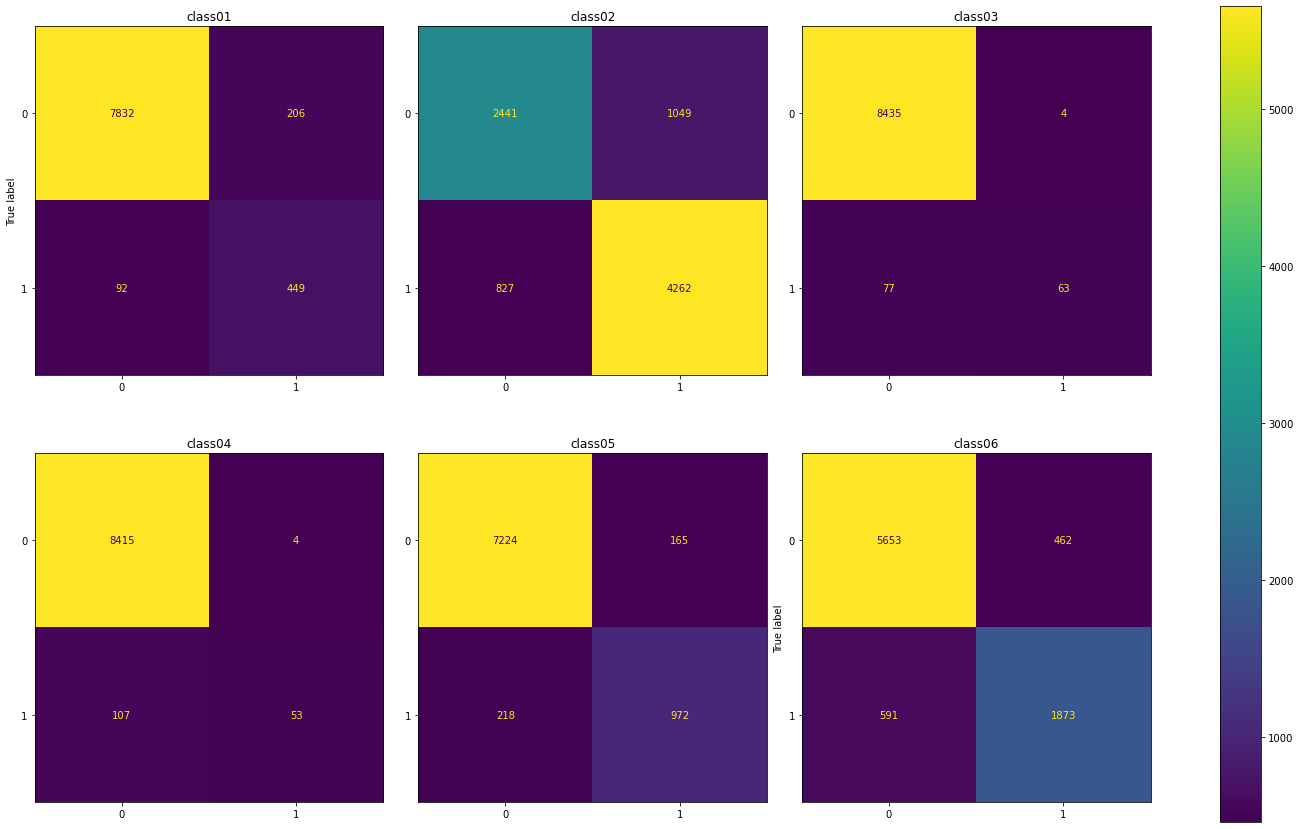

In [16]:

cla_LPowerset = LabelPowerset(RandomForestClassifier())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("RandomForestClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("RandomForestClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()